### Inspect and Clean up the Dataset
Procedures follow the example on the Mask_RCNN GitHub Page: https://github.com/matterport/Mask_RCNN/blob/master/samples/balloon/inspect_balloon_data.ipynb

In [3]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import PIL
from PIL import Image
"""
Need to Install mrcnn

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon
"""
import matplotlib.image as mpimg 

import detectron2
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper



%matplotlib inline

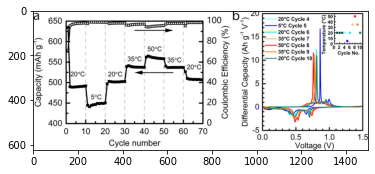

In [48]:
# Import the Detectron2 Transforms module
import detectron2.data.transforms as T

# Can implement this resizing in the dataloader
# dataloader = build_detection_train_loader(cfg,mapper=DatasetMapper(cfg, is_train=True, augmentations=[T.Resize((800, 800))]))

image = detectron2.data.detection_utils.read_image("plot.jpg") # image is nd array
image.shape
plt.imshow(image)

### Image Resize with Detectron2 - Scale to target width and height
This is a built-in function in Detectron that can be used to resize the dataset. This resize likely does not use padding.
https://detectron2.readthedocs.io/en/latest/modules/data_transforms.html


In [70]:
scale = T.ScaleTransform (624, 1500, 500, 500) # this is a class
resized_image = scale.apply_image(image, "bilinear")
resized_image.shape
plt.imshow(resized_image)
plt.show()

TypeError: __init__() missing 2 required positional arguments: 'new_h' and 'new_w'

### Image Resize with Detectron2 -  Resize w.r.t. shortest edge (No scaling)

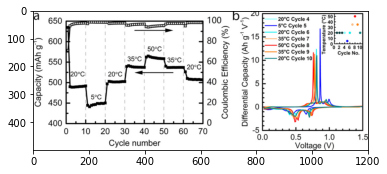

In [63]:
shortest_edge = T.ResizeShortestEdge(500, max_size=9223372036854775807, sample_style='range', interp=2)
shortest_edge_transform = shortest_edge.get_transform(image)
#type(shortest_edge_transform)
new_img = shortest_edge_transform.apply_image(image)
plt.imshow(new_img)
plt.show()

### Image Resize with Detectron2 -  Pad Transform

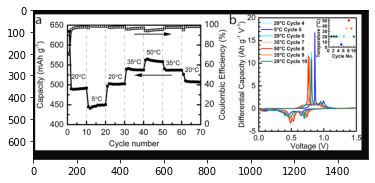

In [64]:
pad = T.PadTransform(10, 20, 30, 40, 624, 1500, pad_value = 10) # number of pixels left,top,right,bottom
new_img = pad.apply_image(image)
plt.imshow(new_img)
plt.show()

### Padding with numpy

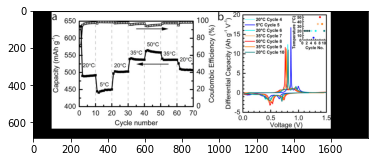

In [65]:
new_img = np.pad(image,((10,50),(100,200),(0,0)))
plt.imshow(new_img)
plt.show()

### Image Resize with MRCNN
This piece of code resize the image and the mask altogether

In [ ]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

### Load image and mask from json
 https://github.com/wkentaro/labelme/blob/master/labelme/cli/json_to_dataset.py#L14


In [ ]:
# Load image
imgs = []
path = "./"
valid_images = [".jpg",".gif",".png"] # acceptable image types
for file in os.listdir(path):
    ext = os.path.splitext(file)[1] # find he extension of the file
    if ext.lower() not in valid_images:
        continue
    # append images to a list of nd arrays
    imgs.append(detectron2.data.detection_utils.read_image(path+file)) 
#plt.imshow(imgs[4])

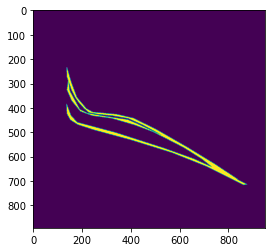

In [68]:
from labelme import utils
import imgviz

data = json.load(open("DischargeCurve_annotatedexample.json"))
imageData = data.get("imageData")
img = utils.img_b64_to_arr(imageData)

label_name_to_value = {"_background_": 0}
for shape in sorted(data["shapes"], key=lambda x: x["label"]):
    label_name = shape["label"]
    if label_name in label_name_to_value:
        label_value = label_name_to_value[label_name]
    else:
        label_value = len(label_name_to_value)
        label_name_to_value[label_name] = label_value
        
lbl, _ = utils.shapes_to_label(img.shape, data["shapes"], label_name_to_value)


label_names = [None] * (max(label_name_to_value.values()) + 1)
for name, value in label_name_to_value.items():
    label_names[value] = name

lbl_viz = imgviz.label2rgb(
    label=lbl, img=imgviz.asgray(img), label_names=label_names, loc="rb"
)

#plt.imshow(img)
plt.imshow(lbl)
#type(lbl_viz)


### Convert Our Data to Dictionary and Register to Detectron2
Procedrues follow the tutorial: https://wendeehsu.medium.com/instance-segmentation-with-detectron2-127fbe01b20b <br/>
We first convert our .json annotation files to Detectron2 dictionary.

In [ ]:
def get_dicts(img_dir):
    """
    This function takes in our annotated json file and convert it to 
    the dictionary file type that is accepted by Detectron2.
    """
    json_file = os.path.join(img_dir, "via_export_json.json") ### Need to set out own directory and json filename here
    
    with open(json_file) as f:
        imgs_anns = json.load(f)
    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
                }
            objs.append(obj)
            print(objs)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

### Unused apporach to output new json files

In [1]:
"""
Intended to save all rescaled image and masks to new json files
but cannot figure out how to save with json.dump()
"""
# Update json files and save as in new directory
img_num = 0
for file in os.listdir(path):
    ext = os.path.splitext(file)[1] # find he extension of the file
    if ext.lower() not in valid_filetype:
        continue
    data = json.load(open(file))
    new_filename = file+"_scaled" # create new json filename
    # Update polygon masks information while keeping the keys
    for index,mask in enumerate(polygon_list[img_num]):
        data["shapes"][index]["points"] = new_masks[img_num][index]
    # Update other dictionary information
    data["imageHeight"] = height
    data["imageWidth"] = width
    data["imagePath"] = path+"./Scaled"+new_filename
    data["imageData"] = utils.img_arr_to_b64(imgs[img_num])
    # Save to new json file
    with open(new_filename, 'w') as json_file:
        print("hi")
        json.dump(data, json_file)
    img_num = img_num+1
    
"""
    
    # Update polygon masks information while keeping the keys
    for index,mask in enumerate(polygon_list[img_num]):
        data["shapes"][index]["points"] = polygon_list[img_num][index]

"""

"""
Save with labeme function

lbf = LabelFile()
lbf.save(
        filename=new_filename,
        shapes=data.get("shapes"),
        imagePath=path+"./Scaled"+new_filename,
        imageHeight=height,
        imageWidth=width,
        imageData=None)

"""
# utils.img_arr_to_b64(imgs[img_num])

NameError: name 'os' is not defined

### Unused peice of code 

In [2]:
# Reshaped polygon list to Detectron2 acceptable format
def polygon_arr_to_list(polygon_list):
    """
    This funtion converts the a list of polygons for multiple images to 
    Detectron2 accpeted format and find the bounding boxes
    """
    reshaped_polygon_list = []
    bb_box_list =[]
    for img, polygons in enumerate(polygon_list):
        #print(polygons)
        reshaped_polys = []
        bb_boxes = []
        for ind, polygon in enumerate(polygons):
            #print(polygon)
            reshaped_poly = polygon.reshape(1,polygon.shape[0]*polygon.shape[1]).tolist()[0]            
            # [min_x, min_y, max_x, max_y]
            bb_box = [np.min(reshaped_poly[0::2]),
                      np.min(reshaped_poly[1::2]),
                      np.max(reshaped_poly[0::2]),
                      np.max(reshaped_poly[1::2])]
            reshaped_polys.append(reshaped_poly)
            bb_boxes.append(bb_box)
        reshaped_polygon_list.append(reshaped_polys)
        bb_box_list.append(bb_boxes)
        
    return reshaped_polygon_list, bb_box_list

### Unused: show image with labelme functions

In [ ]:
matplotlib.rcParams['figure.dpi'] = 100

data = json.load(open("DischargeCurve_annotatedexample.json"))
label_name_to_value = {"_background_": 0,"DischargeCurve": 1}

for shape in sorted(data["shapes"], key=lambda x: x["label"]):
    label_name = shape["label"]
    if label_name in label_name_to_value:
        label_value = label_name_to_value[label_name]
    else:
        label_value = len(label_name_to_value)
        label_name_to_value[label_name] = label_value
        
lbl, _ = utils.shapes_to_label(img.shape, data["shapes"], label_name_to_value)


label_names = [None] * (max(label_name_to_value.values()) + 1)
for name, value in label_name_to_value.items():
    label_names[value] = name

lbl_viz = imgviz.label2rgb(
    label=lbl, img=imgviz.asgray(img), label_names=label_names, loc="rb"
)

#plt.imshow(imgs[0],alpha=1)
plt.imshow(lbl, alpha=0.6)
#type(lbl_viz)
#plt.imshow(new_imgs[0])
#plt.show()
#type(lbl)

Then Register the voltage discharge curve and dqdv curve dataset with Detectron2

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog
path = "/content/drive/.../wendee/images" ##### Need to set the path to our own image directory

for file in ["training_data_discharge_curve", "testing_data_discharge_curve"]:
    DatasetCatalog.register("voltage_discharge_curve_" + file, lambda file=file: get_dicts(path + "/" +  file))
    MetadataCatalog.get("voltage_discharge_curve_" + d).set(thing_classes=["DischargeCurve"])

for file in ["training_data_dqdv_curve", "testing_data_dqdv_curve"]:
    DatasetCatalog.register("dqdv_curve_" + file, lambda file=file: get_dicts(path + "/" +  file))
    MetadataCatalog.get("dqdv_curve_" + d).set(thing_classes=["DqdvCurve"])

Visualize the data to see if it's registered okay.

In [6]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = get_dicts(path + "training_data_discharge_curve")
for data in random.sample(dataset_dicts, 3):
    img = cv2.imread(data["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("voltage_discharge_curve_training_data_discharge_curve"), scale=0.5)
    vis = visualizer.draw_dataset_dict(data)
    cv2_imshow(vis.get_image()[:, :, ::-1])

NameError: name 'd' is not defined